# Hypothesis testing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import statsmodels.api as sm

In [2]:
from matplotlib.lines import Line2D

custom_lines = [
    Line2D([0], [0], color="blue", lw=4),
    Line2D([0], [0], color="red", lw=4),
]
plt.rcParams.update({"mathtext.default": "regular"})

## A tale of two hypotheses

In traditional statistics, there is a strong emphasis on a heavily standardized procedure that is known as **hypothesis testing**. In its vanilla incarnation, this goes as follows. You define two hypotheses:
  - a **null hypothesis** ($H_0$)
  - an **alternative hypothesis** ($H_1$)

You make sure that $H_0$ and $H_1$ are formulated in such a way that:
  - they exclude one another (if $H_0$ is True, then $H_1$ must be False);
  - together, they cover all possible cases (they don't leave room, for instance, for yet another $H_2$ or so). All possible states that you can think of are covered just by the null hypothesis and the alternative hypothesis.

A simple example would be:
  - $H_0$: "On average, Lisa and Mike produce sentences that have the same length."
  - $H_1$: "There is a difference in length between the sentences that Lisa and Mike produce on average."
  
In this example, it will be clear that $H_0$ and $H_1$ cannot both be true at the same time. (Note how the alternative hypothesis can often be formulated as the plain **negation** of the null hypothesis.) Also, all possible situations are covered by $H_0$ and $H_1$.

The formulation above is an example of a **non-directional hypothesis**: we don't care whether Mike's sentences are longer, viz. shorter, than Lisa's; we only state that there is a difference, without specifying the **direction** of that difference. A **directional** variant would be:

  - $H_0$: "On average, Mike doesn't produce sentences that are any longer than Lisa's."
  - $H_1$: "On average, Mike does produce longer sentences than Lisa."

This might only seem like a semantic difference right now, but this directional formulation ("greater than", "shorter than", "less than") has implications for how we run tests.

How do we pick one of these two hypotheses, $H_0$ and $H_1$? Typically, you will try to gather evidence to **reject the null hypothesis**, nudging you, by necessity, to accept the alternative hypothesis (since both hypotheses exclude one another). Often (but not always), the null hypothesis therefore is formulated as the less interesting hypothesis, because it serves as a **strawman** that you have the intention to reject (if the statistics allow you to do that at least). This immediately shows one of the **weaknesses** of traditional hypothesis testing: this methodology is only as interesting as the strawman which you put in place. If you have a really mundane $H_0$, that nobody really expects to be true, then it won't be very impressive if your $H_1$ proves to be more credible than your $H_0$.


###### Basic setup:
#### test $\to$ test statistic $\to$ p-value $\to$ null hypothesis (rejection | acceptance)
> Whether or not you can reject the null hypothesis crucially depends on the p-value for the result of the test. The calculation of the p-value, however, depends on yet another number, the test statistic. We'll first cover this topic therefore.

## A test statistic

In the previous sprint, we introduced the normal distribution, and we said that we specifically introduced it, so that you could understand how a statistical test worked. Why is that?

Most statistical tests will produce a so-called **test statistic**, a single number that is spit out by the procedure. For now, you don't have to care about how this test statistic is produced, since we'll see a detailed example later on. What we do care about is that most tests are designed in a really clever way, in the sense that, ***if the null hypothesis holds*, this number should be drawn from a known distribution**. Often, this will be a normal distribution, of which the mean and standard deviation are known beforehand (precisely because of the clever way in which the test has been designed). If the test statistic would prove highly incompatible with this anticipated distribution, this can be seen as evidence that we should reject the null hypothesis (plainly because the test statistic that we obtain seems incompatible with what we expect).

But then, how can we determine whether the test statistic is incompatible with the distribution that we expect? That is the key question. For answering this question, we'll have to revisit the normal distribution where we left it off in the previous sprint.

### Probability density at a specific point

In the previous sprint, we saw how we can draw from a "bootstrap" normal distribution. Let us recap that for a moment and fit a theoretical normal to the `life.span` variable from our Spanish authors dataset. This technique uses "maximum likelihood estimation" (MLE) to fit the parameters for a standard normal (we would have almost the same result if we just used the empirical parameters, but this technique will be more useful in the future)

Notice (if you look back) that the MLE fitted parameters here are very slightly different to the empirical mean and standard deviation, because they are *estimated* using a complicated algorithm.

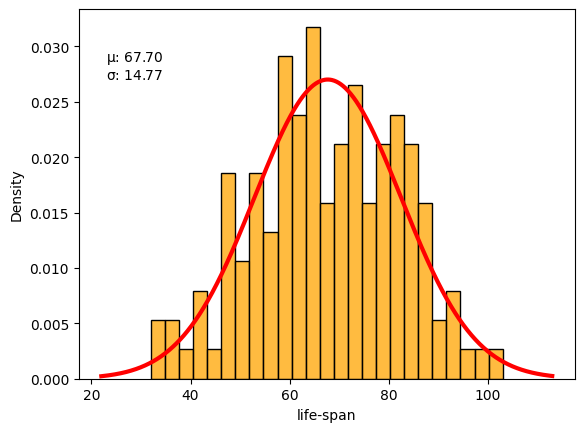

In [3]:
authors = pd.read_csv("../../datasets/correlaciones/sp-authors.tsv", sep="\t")
life_span = authors["life-span"]

# Fitted parameters vary by distribution! For Normal it fits just mean and std
mu, sigma = sp.stats.norm.fit(life_span)
life_dist = sp.stats.norm(loc=mu, scale=sigma)

ax = sns.histplot(
    x=life_span,
    color="orange",
    stat="density",
    bins=25,
)
# 1000 points along the x-axis (we extend the bounds a little)
# Capital X will be used a lot to refer to an X vector
X = np.linspace(life_span.min() - 10, life_span.max() + 10, 1000)

# Fit the normal density value at each point
y_pdf = life_dist.pdf(X)
sns.lineplot(x=X, y=y_pdf, color="red", linewidth=3)
ax.text(23, 0.027, f"$\\mu$: {mu:.2f}\n$\\sigma$: {sigma:.2f}")
plt.show()

Fitting a distribution to our data is not just something that is just useful for making pretty graphs: it allows us to quantify what typical values are in this distribution but also which ranges of values we would *not* expect. Take the `life-span` data for instance: we know that on average an author lived for $\sim$ 67 years and the standard deviation around that mean was $\pm\sim$ 15 years. Suppose that we encounter another author, not included in this sample, and that this author lived for 74 years: that wouldn't really surprise us, as this life span falls well within the standard deviation.

However, suppose that we encounter an author who passed at the much younger age of 27: that should surprise us already much more, and the same would go for an extremely elevated age such as 102. Intuitively, we would say that these numbers aren't impossible, but just much less likely than ages that are closer to the mean. Once we've established the parameters of our distribution, we can easily get the specific **density** for a certain value, given that distribution:

In [4]:
print(life_dist.pdf(67))
print(life_dist.pdf(27))
print(life_dist.pdf(102))

0.02697280803462518
0.0006074460348693059
0.0018235826107390963


Here, we use the function `pdf` attached to the normal distribution object that we fitted to our data earlier. The PDF is a probability **density** function. The returned values correspond to the "height" of the density curve at that specific point:

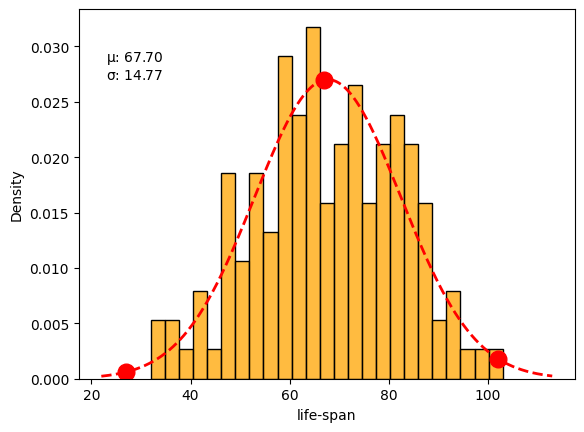

In [5]:
sns.histplot(
    x=life_span,
    color="orange",
    stat="density",
    bins=25,
)
ax = sns.lineplot(x=X, y=y_pdf, color="red", linewidth=2, linestyle="--")
plt.plot(27, life_dist.pdf(27), "ro", markersize=12)
plt.plot(67, life_dist.pdf(67), "ro", markersize=12)
plt.plot(102, life_dist.pdf(102), "ro", markersize=12)
ax.text(23, 0.027, f"$\\mu$: {mu:.2f}\n$\\sigma$: {sigma:.2f}")

plt.show()

You can see how the points intersect the density curve at different heights: there are big differences in the probability mass that is present at these specific points. If you understand this, you are very close to understanding what a $p$-value is.

### Sidebar - Densities are NOT probabilities!

> It would be easy to think about the output of a "probability density function" as being a probability, but this is **NOT THE CASE**. The only way we can obtain a probability from theoretical distributions is by looking at a **range** of x-axis values, using a thing called the CDF (which is coming soon). For "maths reasons" the theoretical probability of any single x-axis value for a 'continuous probaility distribution', like the Gaussian (normal) distribution, **IS ZERO**.

## P-values

Most statistical tests that we will see later on will produce a single number, which is the so-called **test statistic**. These tests are cleverly defined and start from a certain **hypothesis**: if that hypothesis is true, we can assume that this statistic should follow a certain distribution, such as the normal. **Because we know this distribution in advance, we can compare the test statistic to this distribution and quantify our surprise**. If the number is too extreme, given the distribution that we expected, that serves as proof that the original hypothesis cannot be maintained and must be rejected. Deciding *exactly when to reject*, can be done using probability values such as the ones that we just discussed.

First, let us think about the "surprise" of an author dying at 67. What is the probability, according to our fitted normal, of death *by the age of 67*. Remember that *the probability of an exact number is always zero*. 

When we speak of a **p-value** in this context, this value refers to our surprise to observe a value of 67 *or a value that is even lower*. That last addition is crucial: we don't just take the point estimate at 67, we also want to include the probability of even more extreme values (or the integral of the probability density curve on the range $(-\infty, 67)$).

First, let's see what that looks like visually

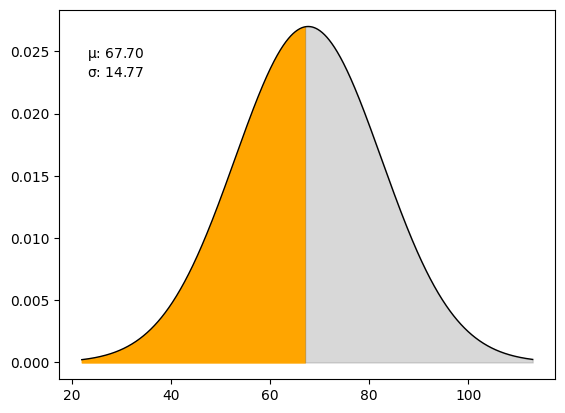

In [6]:
X = np.linspace(life_span.min() - 10, life_span.max() + 10, 1000)

# Fit the normal density value at each point
y_pdf = life_dist.pdf(X)
ax = sns.lineplot(x=X, y=y_pdf, color="black", linewidth=1)
ax.fill_between(X, y_pdf, color="orange", alpha=1, where=(X <= 67))
ax.fill_between(X, y_pdf, color="grey", alpha=0.3, where=(X > 67))
ax.text(23, 0.023, f"$\\mu$: {mu:.2f}\n$\\sigma$: {sigma:.2f}")
plt.show()

To get this estimate we use the `cdf()` method. Unlike the PDF, the CDF is a **cumulative** distribution function. The CDF always tells us how much probability mass is to the *left*

In [7]:
life_dist.cdf(67)

0.48112522508864597

Which tells us that 48% of the probability mass is to the left of 67 (which looks right, visually), so the result is not very surprising. What about someone dying before an age of 102? The CDF tells us that this is extremely not surprising.

In [8]:
life_dist.cdf(102)

0.9898754620456164

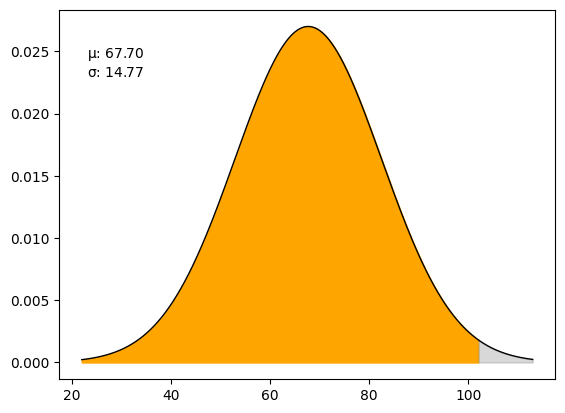

In [9]:
X = np.linspace(life_span.min() - 10, life_span.max() + 10, 1000)
y_pdf = life_dist.pdf(X)
ax = sns.lineplot(x=X, y=y_pdf, color="black", linewidth=1)
ax.text(23, 0.023, f"$\\mu$: {mu:.2f}\n$\\sigma$: {sigma:.2f}")
ax.fill_between(X, y_pdf, color="orange", alpha=1, where=(X <= 102))
ax.fill_between(X, y_pdf, color="grey", alpha=0.3, where=(X > 102))

plt.show()

The shaded area corresponds to our p-value: it shows the surface of the probability mass that we care about when calculating a p-value. If this surface is smaller than some **critical threshold**, such as 0.05, that is typically seen as **sufficient evidence** that we can reject the original hypothesis. We should stress that the critical threshold of 0.05 is common in the Humanities and Social Science but isn't particularly strict: in physics, critical thresholds of 0.001 are not uncommon. You should always keep in mind that the threshold of 0.05 is **just a convention**: the difference between a "significant" $p$-value of 0.049 and an "non-significant" $p$-value of 0.051 is negligible.

## Directional vs non-directional hypotheses

Another way of thinking about our 102 year old author to to ask whether they died at a surprisingly *old* age. However, our shaded graph above doesn't show this. Actually we want to take *all* of the probability mass, and *subtract* the authors that died before 102, this gives us the probability of someone living for 102 years *or more*:

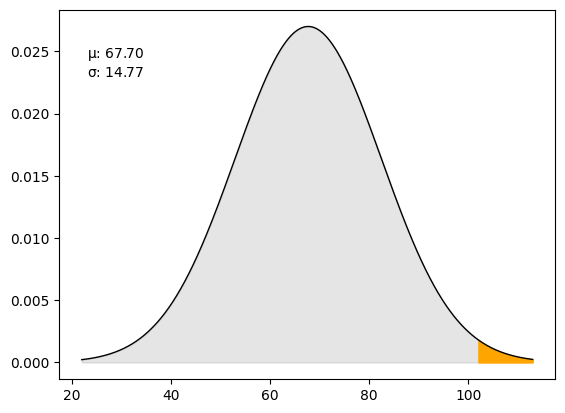

In [10]:
ax = sns.lineplot(x=X, y=y_pdf, color="black", linewidth=1)
ax.fill_between(X, y_pdf, color="grey", alpha=0.2, where=(X <= 102))
ax.fill_between(X, y_pdf, color="orange", alpha=1, where=(X > 102))
ax.text(23, 0.023, f"$\\mu$: {mu:.2f}\n$\\sigma$: {sigma:.2f}")
plt.show()

Since the total probability space (everything that could happen) adds up to 1, and since "lives to <= 102" and "lives to > 102" covers the entire space of possibilities, we can obtain our blue area by subtracted the red area from 1 to get our "surprise" value.

In [11]:
1 - life_dist.cdf(102)

0.010124537954383617

> Exercise (HARD)
>
> Do you think you can calculate the probability of someone living precisely 60 to 80 years?


In [12]:
life_dist.cdf(80) - life_dist.cdf(60)

0.4963275055851728

Let us go back to our initial example of an `H0`-`H1` pair:

  - $H_0$: "On average, Lisa and Mike produce sentences that have the same length."
  - $H_1$: "There is a difference in length between the sentences that Lisa and Mike produce on average."
  
This is an example of a non-directional hypothesis: we don't care whether Mike's sentences are longer than Lisa's on average -- we only care whether there is a difference at all.

If we'd like to study this difference statistically, what we would do is run a test that produces a test statistic that captures the *differences in length between two groups of sentences*: a sample for Mike and a sample for Lisa. Intuitively, you can understand that, **if this test statistic would be normally distributed, the mean would be somewhere around zero**: if their sentences are equally long, the test statistic should be somewhere around zero, but allowing for some spread around that mean difference (which will never be exactly zero, because of limited sample sizes or other noisy factors). Therefore, we could assume that the expected distribution of this statistic would look at little like, *if the null hypothesis were true*:

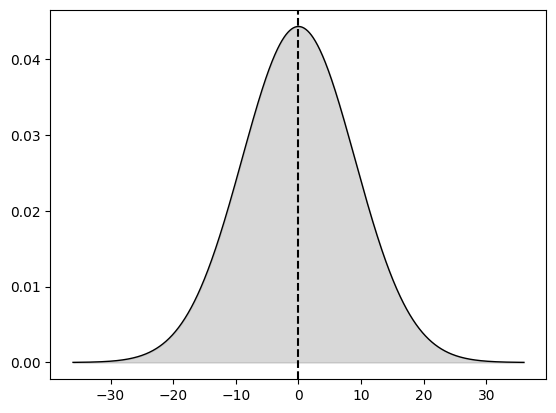

In [13]:
dist_diff = sp.stats.norm(loc=0, scale=9)
X_dist = np.linspace(-36, 36, 1000)
y_dist = dist_diff.pdf(X_dist)
ax = sns.lineplot(x=X_dist, y=y_dist, color="black", linewidth=1)
ax.fill_between(X_dist, y_dist, color="grey", alpha=0.3)
ax.axvline(0, color="black", linestyle="--")

plt.show()

The vertical line in this plot indicates the exact mean value (of zero), but if we randomly sample sentences from Mike and Lisa, it's very unlikely that the test statistic would be exactly zero (implying that *all* of their sentences were of the exact same length). Because of this kind of sample noise, we should be lenient and allow for some "wiggle" around the perfect mean of zero in our expected distribution. How much *lenience* we have to show, is often a matter of interpretation, but it should be clear that **the further a test statistic moves away from the expected mean, into the tails of the distribution (in either direction), the more doubts we should have that the test statistic is compatible with the expected distribution**.

Compare the following two test statistics, given our expected distribution:

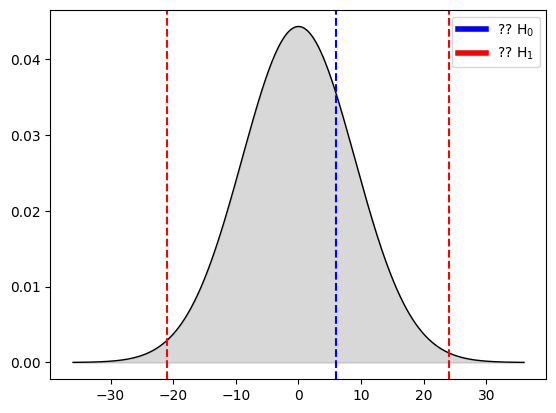

In [14]:
dist_diff = sp.stats.norm(loc=0, scale=9)
X_dist = np.linspace(-36, 36, 1000)
y_dist = dist_diff.pdf(X_dist)
ax = sns.lineplot(x=X_dist, y=y_dist, color="black", linewidth=1)
ax.fill_between(X_dist, y_dist, color="grey", alpha=0.3)
ax.axvline(-21, color="red", linestyle="--")
ax.axvline(24, color="red", linestyle="--")
ax.axvline(6, color="blue", linestyle="--")
ax.legend(custom_lines, ["?? $H_0$", "?? $H_1$"])

Clearly the value for the blue line is much more in line with our expectations than those for the red lines, that move well into the **lower tail** and **upper tail** of our distribution. For our present case, we don't really care in which direction the test statistic moves (to the left or the right of the mean): that is because our hypothesis doesn't have a direction.

For each of the red lines above, we can calculate a $p$-value and capture how strongly they move into the tails: remember that is is the probability mass:
 - to the left of the test statistic (if it is lower than the mean)
 - to the right of the test statistic (if it is higher than the mean)

In [15]:
low = dist_diff.cdf(-21)
high = 1 - dist_diff.cdf(24)
print(f"p-value for low distance (-21): {low:.4f}")
print(f"p-value for high distance (24): {high:.4f}")

p-value for low distance (-21): 0.0098
p-value for high distance (24): 0.0038


## Deciding in advance

There is one more function, which you don't need to think about too much for now, called a PPF, for "percent point function". This is basically the inverse of the CDF. The CDF tells us percents for values (like the percent of the mass to the left of -21) and the PPF tells us values for percents (what value would yield a value of exactly 0.05). We will use this to define three 'confidence thresholds' in advance.

In [16]:
conf_95 = dist_diff.ppf(1 - 0.025)
conf_99 = dist_diff.ppf(1 - 0.005)
conf_999 = dist_diff.ppf(1 - 0.0005)

Using a **critical threshold** we can set a clear criterion, *in advance*, to decide whether or not the the test statistic is significantly "surprising", given what we expected. The implications are important: if the probability of our test statistic is lower than this critical threshold, we can reject $H_0$, and automatically accept $H_1$ (since they exclude one another). Compare the following cases, where we increasingly set a lower threshold:

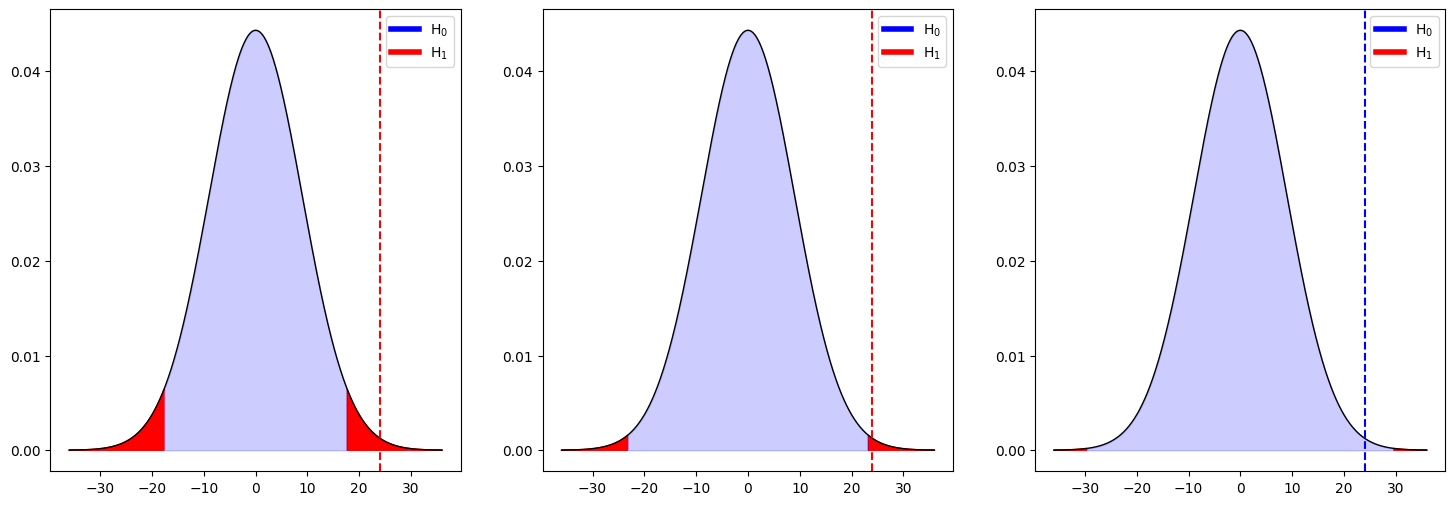

In [17]:
fig, axs = plt.subplots(ncols=3, figsize=(18, 6))

# This isn't a coding course! But sometimes we'll use some code ;)
for idx, conf_lvl in enumerate([conf_95, conf_99, conf_999]):
    sns.lineplot(x=X_dist, y=y_dist, color="black", linewidth=1, ax=axs[idx])
    axs[idx].fill_between(
        X_dist,
        y_dist,
        color="red",
        alpha=1,
        where=((X_dist < -conf_lvl) | (X_dist > conf_lvl)),
    )
    axs[idx].fill_between(
        X_dist,
        y_dist,
        color="blue",
        alpha=0.2,
        where=((X_dist > -conf_lvl) & (X_dist < conf_lvl)),
    )
    if 24 > conf_lvl:
        col = "red"
    else:
        col = "blue"
    axs[idx].axvline(24, color=col, linestyle="--")
    axs[idx].legend(custom_lines, ["$H_0$", "$H_1$"])

The threshold obviously affects how quickly you accept or reject the test statistic: the first two cases show a pretty strict threshold that would be quick to reject a test statistic of 24. Only in the last and strictest case, we'd still maintain the null hypothesis, as the red line is safely out of the range of the (shaded) upper tail.

## Directional hypothesis

In the previous section, we dealt with an undirectional hypothesis. We didn't care whether:
 - Mike's sentences were longer, viz. shorter, than Lisa's
 - our statistic moved away from the mean towards the **lower tail** or the **upper tail** of the distribution
 
Just declaring "there's a difference", however, isn't very interesting however. It would be more insightful to know who then produces the longest sentences: Mike or Lisa? In other words, there might an effect, but we still don't don't the **direction** of that effect. We could therefore choose to phrase our hypotheses as follows:

  - $H_0$: "On average, Mike produce sentences of the same length (or shorter) as Lisa."
  - $H_1$: "On average, Mike produces *longer* sentences than Lisa."
  
Suppose that our test statistic moves to the right of the mean, the more Mike's sentences turn out to be longer than Lisa's. How much longer would Mike's sentences have to be before we reject the null hypothesis? In this case, crucially, we don't care about the lower tail anymore: we only care to which extent the red moves moves into the upper tail (since we assume that that direction indicates that Mike's sentences are longer):

In [18]:
conf_95 = dist_diff.ppf(1 - 0.05)
conf_99 = dist_diff.ppf(1 - 0.01)

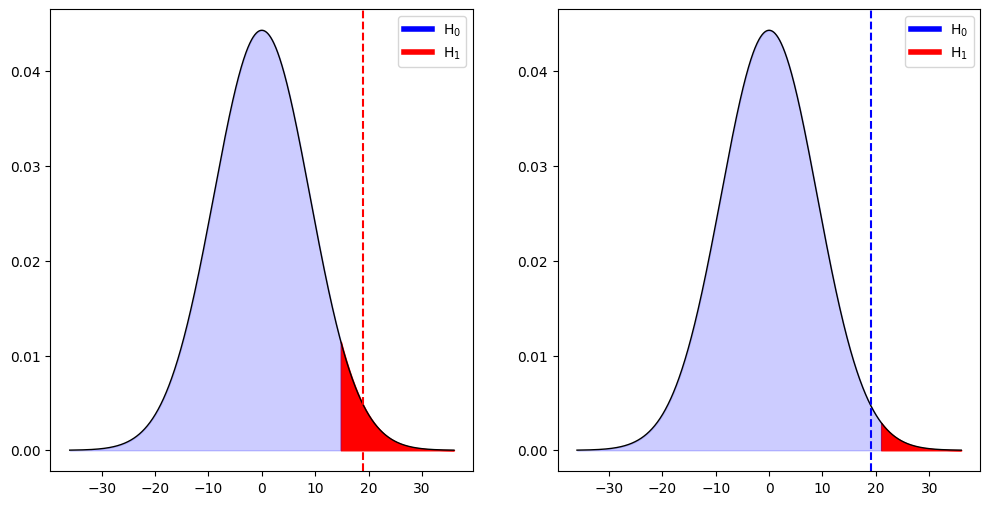

In [19]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

for idx, conf_lvl in enumerate([conf_95, conf_99]):
    sns.lineplot(x=X_dist, y=y_dist, color="black", linewidth=1, ax=axs[idx])
    axs[idx].fill_between(
        X_dist,
        y_dist,
        color="red",
        alpha=1,
        where=((X_dist > conf_lvl)),
    )
    axs[idx].fill_between(
        X_dist,
        y_dist,
        color="blue",
        alpha=0.2,
        where=((X_dist < conf_lvl)),
    )
    if 19 > conf_lvl:
        col = "red"
    else:
        col = "blue"
    axs[idx].axvline(19, color=col, linestyle="--")
    axs[idx].legend(custom_lines, ["$H_0$", "$H_1$"])

In this case, one of the test statistics would offer grounds to accept the null hypothesis; the other would suggest that we reject the null hypothesis. We fully ignore the lower tail, which is why *directional* hypotheses are checked using **one-tailed** tests and *undirectional* hypotheses using **two-tailed tests**.

Most statistical tests allow you to simply specify in the function call which variant of the tests you'd like to use and whether you'd like to ignore one of the tails or consider both. Additionally, you can easily decide and set the critical threshold (AKA **significance level**) that you'd like to use.

However, there are two crucial insights that you have to take away from this sprint. First of all, you have to decide whether you'd like to perform a one-tailed or a two-tailed test and **you cannot change that choice afterwards**, as this is considered bad statistical practice. Because of this, you'd better make a scientifically informed choice that builds upon a clear theoretical insight or practical expectation. If you have no reason to assume that Mike's sentences would be longer than Lisa's, use a two-tailed test. If you'd know already, that men's sentences are longer than women's sentences, that would be a good reason to go for a directional variant and apply a one-tailed test.

Why do we stress this? With a two-tailed test, you have two tails and, consequently, just a higher chance to get a test statistic that falls in one of the shaded regions on either side. Thus, you have to apply a stricter critical thresholds for a two-tailed test -- otherwise, you'd be cheating since it would be much easier to get a significant result. How do people correct for this? For a one-tailed test, you can for instance use $p = 0.05$; but for a two-tailed test, you'd apply half that $p = 0.05/2 = 0.025$. The idea is here that, as a researcher, you get brownie points for taking a clear stance and formulate a direction: if you choose a directional hypothesis, you can lower your critical threshold. Choose wisely, however: if your directional hypothesis doesn't reach the desired critical threshold, you're not allowed to rephrase the hypothesis to an directional form to obtain a more desirable $p$-value. (That's a practice known as **$p$-fishing** or **$p$-hacking**.)

<img src=https://www.smbc-comics.com/comics/1567961333-20190908.png />

```
Version History

Current: v1.0.2

22/9/24: 1.0.0: first draft, BN
23/9/24: 1.0.1: improve flow, BN
04/10/24: 1.0.2: typos + proofreading, MK
```